<a href="https://colab.research.google.com/github/hariomshahu/hariomshahu-covid19-lung-ct-scans-classification/blob/main/covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir ~/.kaggle

In [5]:
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle_api_credentials/kaggle.json" ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/Colab Notebooks/kaggle_api_credentials/kaggle.json': No such file or directory


In [6]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [7]:
!kaggle datasets download mehradaria/covid19-lung-ct-scans

Dataset URL: https://www.kaggle.com/datasets/mehradaria/covid19-lung-ct-scans
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 1.02G/1.02G [01:06<00:00, 14.5MB/s]
100% 1.02G/1.02G [01:06<00:00, 16.4MB/s]


In [8]:
!unzip covid19-lung-ct-scans.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Lung_CT_Scans/COVID-19/COVID-19_3441.png  
  inflating: COVID-19_Lung_CT_Scans/COVID-19/COVID-19_3442.png  
  inflating: COVID-19_Lung_CT_Scans/COVID-19/COVID-19_3443.png  
  inflating: COVID-19_Lung_CT_Scans/COVID-19/COVID-19_3444.png  
  inflating: COVID-19_Lung_CT_Scans/COVID-19/COVID-19_3445.png  
  inflating: COVID-19_Lung_CT_Scans/COVID-19/COVID-19_3446.png  
  inflating: COVID-19_Lung_CT_Scans/COVID-19/COVID-19_3447.png  
  inflating: COVID-19_Lung_CT_Scans/COVID-19/COVID-19_3448.png  
  inflating: COVID-19_Lung_CT_Scans/COVID-19/COVID-19_3449.png  
  inflating: COVID-19_Lung_CT_Scans/COVID-19/COVID-19_3450.png  
  inflating: COVID-19_Lung_CT_Scans/COVID-19/COVID-19_3451.png  
  inflating: COVID-19_Lung_CT_Scans/COVID-19/COVID-19_3452.png  
  inflating: COVID-19_Lung_CT_Scans/COVID-19/COVID-19_3453.png  
  inflating: COVID-19_Lung_CT_Scans/COVID-19/COVID-19_3454.png  
  inflating: COVID-19_Lung_CT_Scans/COV

In [9]:
# Initialize lists to store file paths and corresponding labels
import os
covid_dir = "/content/COVID-19_Lung_CT_Scans/COVID-19"
noncovid_dir = "/content/COVID-19_Lung_CT_Scans/Non-COVID-19"
image_paths = []
labels = []

# Iterate over COVID-19 images
for filename in os.listdir(covid_dir):
    if filename != 'desktop.ini' and os.path.isfile(os.path.join(covid_dir, filename)):
        # Append image path to the list
        image_paths.append(os.path.join(covid_dir, filename))
        # Append label (COVID-19)
        labels.append("COVID-19")

# Iterate over Non-COVID-19 images
for filename in os.listdir(noncovid_dir):
    if filename != 'desktop.ini' and os.path.isfile(os.path.join(noncovid_dir, filename)):
        # Append image path to the list
        image_paths.append(os.path.join(noncovid_dir, filename))
        # Append label (Non-COVID-19)
        labels.append("Non-COVID-19")

# Print counts
print("COVID-19 images count:", labels.count("COVID-19"))
print("Non-COVID-19 images count:", labels.count("Non-COVID-19"))


COVID-19 images count: 7495
Non-COVID-19 images count: 944


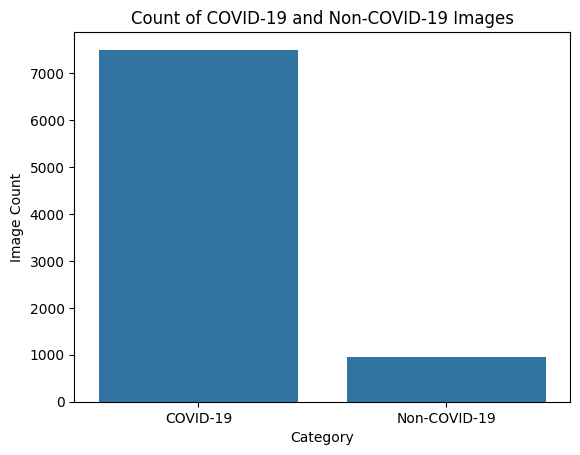

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define the counts based on the labels obtained from directory names
count_covid = labels.count("COVID-19")
count_noncovid = labels.count("Non-COVID-19")

data = {'Category': ['COVID-19', 'Non-COVID-19'], 'Count': [count_covid, count_noncovid]}
df = pd.DataFrame(data)

sns.barplot(x='Category', y='Count', data=df)
plt.title('Count of COVID-19 and Non-COVID-19 Images')
plt.xlabel('Category')
plt.ylabel('Image Count')
plt.show()


In [11]:
import tensorflow as tf

try:
    # Attempt to initialize for TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Number of replicas:', strategy.num_replicas_in_sync)

except ValueError:
    # If TPU is not available, initialize for GPU
    print("TPU not found. Initializing for GPU.")

    # Check if multiple GPUs are available
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if len(gpus) > 1:
        print('Multiple GPUs detected. Using synchronous data parallelism.')
        strategy = tf.distribute.MirroredStrategy()
    else:
        strategy = tf.distribute.get_strategy()
        print('Number of replicas:', strategy.num_replicas_in_sync)

print("Tensorflow version ", tf.__version__)

TPU not found. Initializing for GPU.
Number of replicas: 1
Tensorflow version  2.15.0


In [12]:
#DATA PREPROCESSING PIPELINE

import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

CLASSES = ['COVID-19', 'Non-COVID-19']
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 128 * strategy.num_replicas_in_sync
AUTOTUNE = tf.data.experimental.AUTOTUNE

def preprocess_image(image_path, label):
    # Load and preprocess the image
    try:
      img = tf.io.read_file(image_path)
      img = tf.image.decode_png(img, channels=3)
      img = tf.image.convert_image_dtype(img, tf.float32)
      img = tf.image.resize(img, IMAGE_SIZE)
      label = tf.cast(tf.equal(label, CLASSES[0]), tf.int32)
      # Perform one-hot encoding for the labels
      label = tf.one_hot(label, 2)
      return img, label
    except tf.errors.InvalidArgumentError:
        # Skip this file if it has an unsupported format
        return None, None



# shuffle the file paths randomly
combined = list(zip(image_paths, labels))
random.shuffle(combined)
image_paths[:], labels[:] = zip(*combined)

# Split dataset into train, validation, and test sets
train_image_paths, temp_image_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)
val_image_paths, test_image_paths, val_labels, test_labels = train_test_split(
    temp_image_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels))

Test_IMG_COUNT = tf.data.experimental.cardinality(test_dataset).numpy()

# Apply preprocessing to each dataset
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Prefetch data for better performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



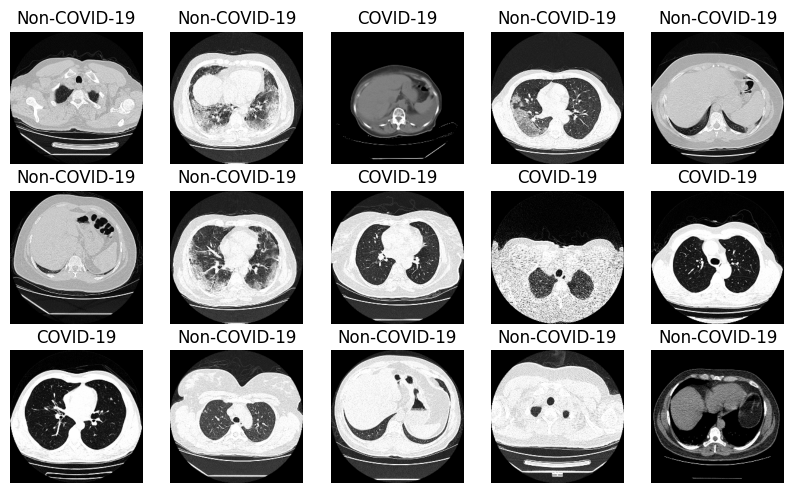

In [13]:
#checking if images are correctly loaded
import numpy as np
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASSES[np.argmax(label_batch[n])])
        plt.axis("off")

image_batch, label_batch = next(iter(train_dataset))
show_batch(image_batch.numpy(), label_batch.numpy())

In [14]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

BATCH_SIZE = 128 * strategy.num_replicas_in_sync

# classes and number of classes
CLASSES = ['COVID-19', 'Non-COVID-19']
NUM_CLASSES = len(CLASSES)

# loss function and metrics
LOSS = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
METRICS = ['accuracy']

# training parameters
Epochs = 50
Early_Stop = 25
#OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_filepath = "/content/drive/My Drive/Colab Notebooks/models/covid19model/best_covid19model.h5"


In [15]:
# Tackleing class imbalance problem


def calculate_class_weights():

    # Total number of instances
    total_count = count_covid + count_noncovid;

    # Number of classes
    num_classes = 2

    weight_covid = (1 / count_covid) * total_count / num_classes
    weight_noncovid = (1 / count_noncovid) * total_count / num_classes

    class_weights = {0: weight_covid, 1: weight_noncovid}  #COVID-19 is class 0, Non-COVID-19 is class 1

    print(f'Weight for class 0 (covid): {weight_covid}')
    print(f'Weight for class 1 (noncovid): {weight_noncovid}')

    return class_weights

class_weights = calculate_class_weights()



Weight for class 0 (covid): 0.5629753168779186
Weight for class 1 (noncovid): 4.469809322033898


In [16]:
# CosineDecayRestarts schedule
initial_learning_rate = 1e-3
first_decay_steps = 50

lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=first_decay_steps
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

Callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=2, mode='min', min_delta=0.0001, cooldown=1, min_lr=1e-6),
    ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=2, save_best_only=True, save_weights_only=False, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=Early_Stop, mode='auto', min_delta=0.00001, verbose=2, restore_best_weights=True)
]

In [17]:
import tensorflow.keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import VGG16

input_shape = (224, 224, 3)

img_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomContrast(factor=0.20)
], name="Augmentation")

def build_model(OPTIMIZER, LOSS, METRICS):
    inputs = layers.Input(shape=input_shape)
    x = img_augmentation(inputs)
    baseModel = VGG16(include_top=False, input_tensor=x, weights="imagenet", pooling ='avg')
    baseModel.trainable = False

    x = layers.BatchNormalization(axis=-1, name="Batch-Normalization-1")(baseModel.output)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
    x = layers.BatchNormalization(axis=-1, name="Batch-Normalization-2")(x)
    x = layers.Dropout(.2, name="Dropout-1")(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization(axis=-1, name="Batch-Normalization-3")(x)

    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="Classifier")(x)
    model = tf.keras.Model(inputs=baseModel.input, outputs=outputs, name="Deep-COVID")

    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

    return model


In [18]:
with strategy.scope():
    model = build_model(optimizer, LOSS, METRICS)

58889256/58889256 [==============================] - 3s 0us/step


In [19]:
# training
history = model.fit(train_dataset, validation_data=val_dataset, epochs=Epochs, class_weight=class_weights, callbacks=Callbacks)

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 2.4953 - accuracy: 0.8233
Epoch 1: val_accuracy improved from -inf to 0.89415, saving model to /content/drive/My Drive/Colab Notebooks/models/covid19model/best_covid19model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 121s 2s/step - loss: 2.4953 - accuracy: 0.8233 - val_loss: 0.6820 - val_accuracy: 0.8942 - lr: 1.5708e-05
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 1.7713 - accuracy: 0.9538
Epoch 2: val_accuracy did not improve from 0.89415
47/47 [==============================] - 51s 666ms/step - loss: 1.7713 - accuracy: 0.9538 - val_loss: 0.6017 - val_accuracy: 0.8878 - lr: 6.0907e-04
Epoch 3/50
47/47 [==============================] - ETA: 0s - loss: 1.6063 - accuracy: 0.9771
Epoch 3: val_accuracy did not improve from 0.89415
47/47 [==============================] - 52s 678ms/step - loss: 1.6063 - accuracy: 0.9771 - val_loss: 0.5966 - val_accuracy: 0.8886 - lr: 2.4472e-05
Epoch 4/50
47/47 [==============================] - ETA: 0s - loss: 1.5757 - accuracy: 0.9810
Epoch 4: val_accuracy did not improve from 0.89415
47/47 [==============================] - 56s 768ms/step - loss: 1.5757 - accuracy: 0.9810 - val_loss: 0.5929 - val_accur

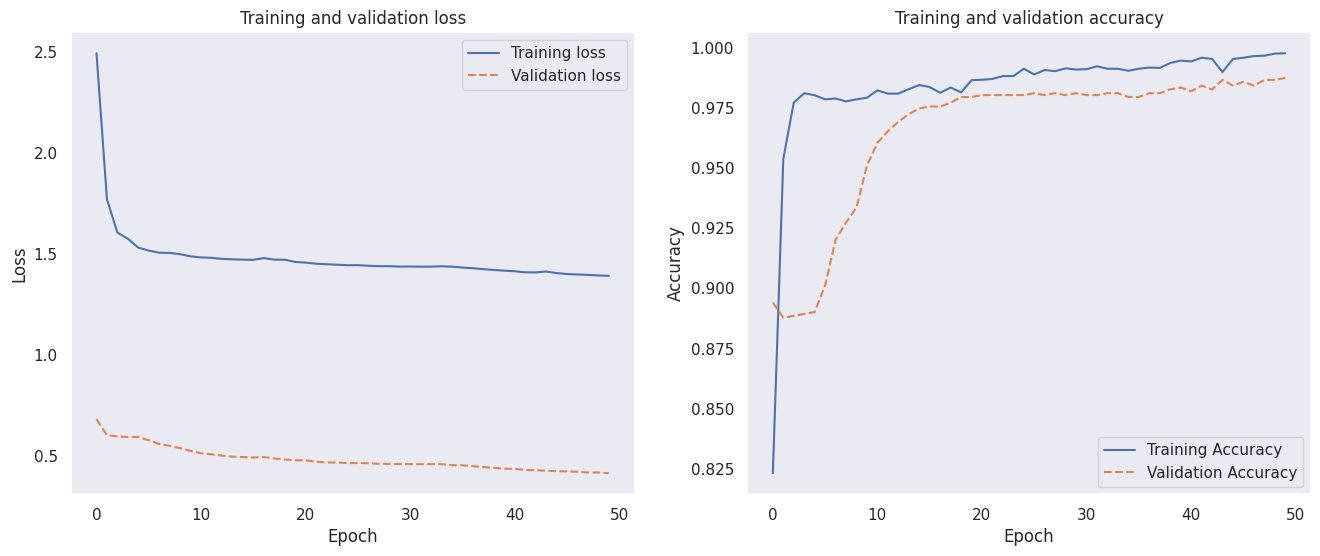

In [20]:
def Plot_Learning_Curves():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    sns.set(style="dark")
    plt.rcParams['figure.figsize'] = (16, 6)

    plt.subplot(1,2,1)
    plt.plot(loss, label='Training loss')
    plt.plot(val_loss, linestyle="--", label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, linestyle="--", label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

Plot_Learning_Curves()

In [21]:
results = model.evaluate(test_dataset, return_dict=True)
print ('\nModel Evaluation:')
print(results['accuracy']*100)

10/10 [==============================] - 7s 664ms/step - loss: 0.4164 - accuracy: 0.9842

Model Evaluation:
98.42022061347961


In [22]:
model = load_model(model_filepath)

results = model.evaluate(test_dataset, return_dict=True)
print ('\nModel Evaluation:')
print(results['accuracy']*100)

10/10 [==============================] - 6s 508ms/step - loss: 0.4164 - accuracy: 0.9842

Model Evaluation:
98.42022061347961


Testing images count: 1266
Evaluation Dataset:
X shape:  (1266, 224, 224, 3)  Y shape:  (1266, 2)
40/40 [==============================] - 17s 255ms/step
Shape of preds:  (1266, 2)


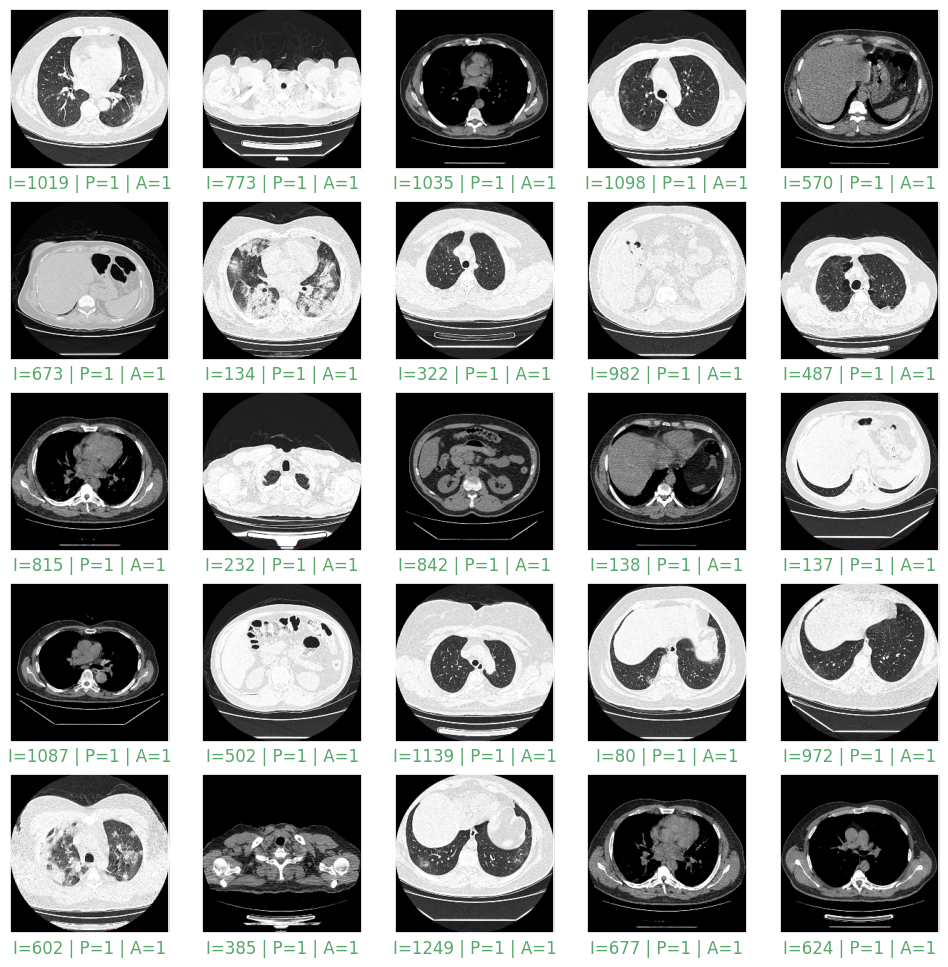

In [23]:
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break
    return numpy_images, numpy_labels


print("Testing images count: " + str(Test_IMG_COUNT))

x_test, y_test = dataset_to_numpy_util(test_dataset, Test_IMG_COUNT)

print("Evaluation Dataset:")
print('X shape: ', x_test.shape,' Y shape: ', y_test.shape)


preds = model.predict(x_test)
print('Shape of preds: ', preds.shape)
plt.figure(figsize = (12, 12))

R = np.random.choice(preds.shape[0])

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    R = np.random.choice(preds.shape[0])
    pred = np.argmax(preds[R])
    actual = np.argmax(y_test[R])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('I={} | P={} | A={}'.format(R, pred, actual), color = col)
    plt.imshow(((x_test[R]* 255).astype(np.uint8)), cmap='binary')
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn import metrics

categories = ['COVID-19', 'Non-COVID-19']
preds = np.round(preds,0)
class_metrics = metrics.classification_report(y_test, preds, target_names = categories, zero_division = 0)
print (class_metrics)

              precision    recall  f1-score   support

    COVID-19       0.99      0.87      0.92       141
Non-COVID-19       0.98      1.00      0.99      1125

   micro avg       0.98      0.98      0.98      1266
   macro avg       0.99      0.93      0.96      1266
weighted avg       0.98      0.98      0.98      1266
 samples avg       0.98      0.98      0.98      1266



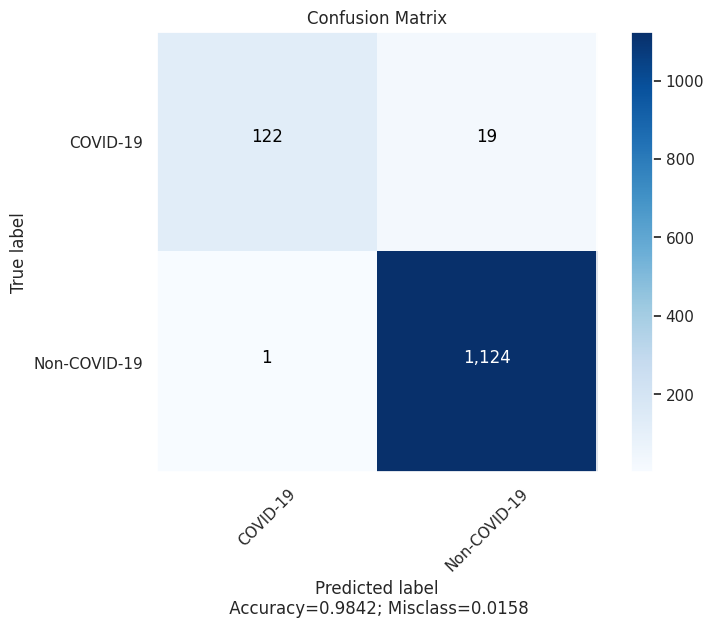

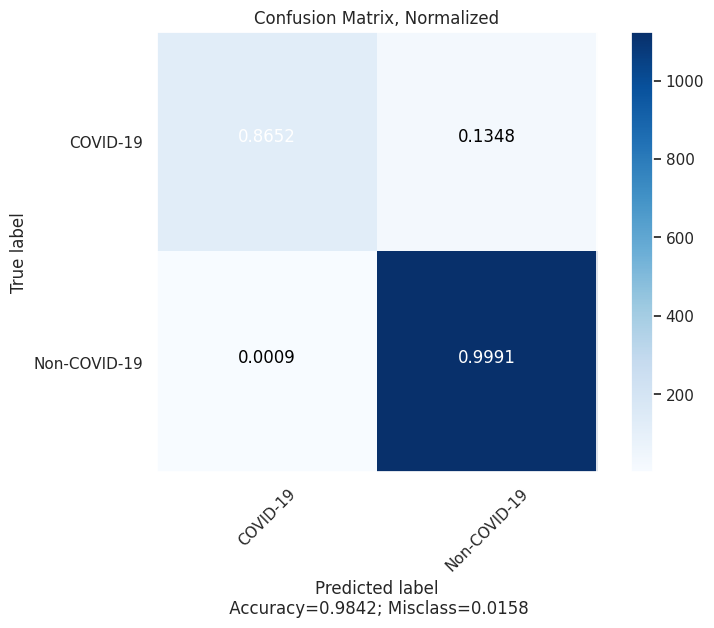

In [25]:
import itertools

matrix = metrics.confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    sns.set(style="dark")
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n Accuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

plot_confusion_matrix(cm           = np.array(matrix),
                      normalize    = False,
                      target_names = categories,
                      title        = "Confusion Matrix")

plot_confusion_matrix(cm           = np.array(matrix),
                      normalize    = True,
                      target_names = categories,
                      title        = "Confusion Matrix, Normalized")

In [26]:
test_image = x_test[0]
x = np.expand_dims(test_image, axis=0)
x = x/255

images = np.vstack([x])

classes = model.predict(images, batch_size=BATCH_SIZE)
classes = np.argmax(classes,axis=1)

print ('Class:', categories[int(classes)] )

1/1 [==============================] - 1s 1s/step
Class: COVID-19


<ipython-input-26-a40d8b21825f>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print ('Class:', categories[int(classes)] )


In [27]:
FP = matrix.sum(axis=0) - np.diag(matrix)
FN = matrix.sum(axis=1) - np.diag(matrix)
TP = np.diag(matrix)
TN = matrix[:].sum() - (FP + FN + TP)

TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
FPR = FP/(FP+TN)
FNR = FN/(TP+FN)
FDR = FP/(TP+FP)

ACC = (TP+TN)/(TP+FP+FN+TN)

print('Other Metrics:')
MSE = mean_squared_error(y_test, preds)

print('MSE:', MSE)
print('Accuracy:', ACC)
print('Precision (positive predictive value):', PPV)
print('Recall (Sensitivity, hit rate, true positive rate):', TPR)
print('Specificity (true negative rate):', TNR)
print('Negative Predictive Value:', NPV)
print('Fall out (false positive rate):', FPR)
print('False Negative Rate:', FNR)
print('False discovery rate:', FDR)

Other Metrics:
MSE: 0.015797788
Accuracy: [0.98420221 0.98420221]
Precision (positive predictive value): [0.99186992 0.98337708]
Recall (Sensitivity, hit rate, true positive rate): [0.86524823 0.99911111]
Specificity (true negative rate): [0.99911111 0.86524823]
Negative Predictive Value: [0.98337708 0.99186992]
Fall out (false positive rate): [0.00088889 0.13475177]
False Negative Rate: [0.13475177 0.00088889]
False discovery rate: [0.00813008 0.01662292]


In [29]:
from tabulate import tabulate
table_data = [
    ['MSE', mean_squared_error(y_test, preds)],
    ['Accuracy', np.mean(ACC)],
    ['Precision (PPV)', np.mean(PPV)],
    ['Recall (TPR)', np.mean(TPR)],
    ['Specificity (TNR)', np.mean(TNR)],
    ['Negative Predictive Value (NPV)', np.mean(NPV)],
    ['Fall out (FPR)', np.mean(FPR)],
    ['False Negative Rate (FNR)', np.mean(FNR)],
    ['False discovery rate (FDR)', np.mean(FDR)]
]

# Print the table
print(tabulate(table_data, headers=['Metric', 'Value']))

Metric                               Value
-------------------------------  ---------
MSE                              0.0157978
Accuracy                         0.984202
Precision (PPV)                  0.987623
Recall (TPR)                     0.93218
Specificity (TNR)                0.93218
Negative Predictive Value (NPV)  0.987623
Fall out (FPR)                   0.0678203
False Negative Rate (FNR)        0.0678203
False discovery rate (FDR)       0.0123765
